# for 2022.10.02, we will observe back-up for the first few hours and then switch to main program

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from astropy import coordinates
from astropy import units as u
from skipper import observe, planner

In [3]:
import sys
sys.path.append('../scripts/')

In [4]:
import sigjson_f2022b
import our_pointings

In [5]:
obsdates = sigjson_f2022b.obsdates

obskeys = [ f'{x[0]:02d}-{x[1]:02d}-{x[2]:02d}' for x in obsdates[:,:3]]

def wrapRA(ra, wrap_point=180.):
    mask = ra >= wrap_point
    wrapped_ra = ra.copy()
    wrapped_ra[mask] -= 360.
    return wrapped_ra

In [6]:
tele_fname = '/Users/kadofong/Downloads/tele20220930.csv'
copilot_fname = '/Users/kadofong/Downloads/db_merian.fits'

In [18]:
obsdates = sigjson_f2022b.obsdates
obsfilters = sigjson_f2022b.obsfilters

oiii_nights = obsdates[obsfilters == 'N540', :-1]
halpha_nights = obsdates[obsfilters=='N708',:-1]

In [ ]:
hcat, ocat = our_pointings.load_fallfields ()

coo_o = observe.CopilotOutput ( copilot_fname, ocat, skySB_0=22.1 )
coo_h = observe.CopilotOutput ( copilot_fname, hcat, skySB_0=21. )

# OIII observations

In [19]:
night = [2022, 10, 2]

In [21]:
#night = oiii_nights[3]

dt = f'{night[0]}{night[1]:02d}{night[2]:02d}' #20220920
if not os.path.exists ( f'../json/{dt}'):
    os.mkdir(f'../json/{dt}')
    
stdout = sys.stdout
with open(f'../json/{dt}/output.log','w') as sys.stdout:
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, 
                                             copilot_fname, mfilt='N540', is_queued=None, #slot=slot,
                                             pad_last_hour=True, maxairmass=1.8, save=True, verbose=True)
sys.stdout = stdout

#os.rename( f'../json/{dt}', f'../json/{dt}_intermediateOIII')

In [28]:
# \\ we're only going to use the second hour (UTC 01)
hours_to_transfer = ['20221001_00', '20221001_01']
going_to_observe = is_queued.loc[np.in1d(is_queued['qstamp'], hours_to_transfer)]

In [29]:
tele = pd.read_csv(tele_fname, index_col=0)
tele_dt = pd.to_datetime(tele['date'])
lastnight = pd._libs.tslibs.timestamps.Timestamp(year=night[0], month=night[1], day=night[2]-2, tz='UTC')
observed_last_night = tele.loc[tele_dt.apply(lambda x: x > lastnight),'object']
lastnightobjects = np.in1d(ocat['object'], observed_last_night)
beforelastnight = np.in1d(ocat['object'], tele.loc[tele_dt.apply(lambda x: x < lastnight),'object'] )

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_29460/101638592.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  going_to_observe['odate'] = going_to_observe.apply(lambda x: x['qstamp'].split("_")[0], axis=1)


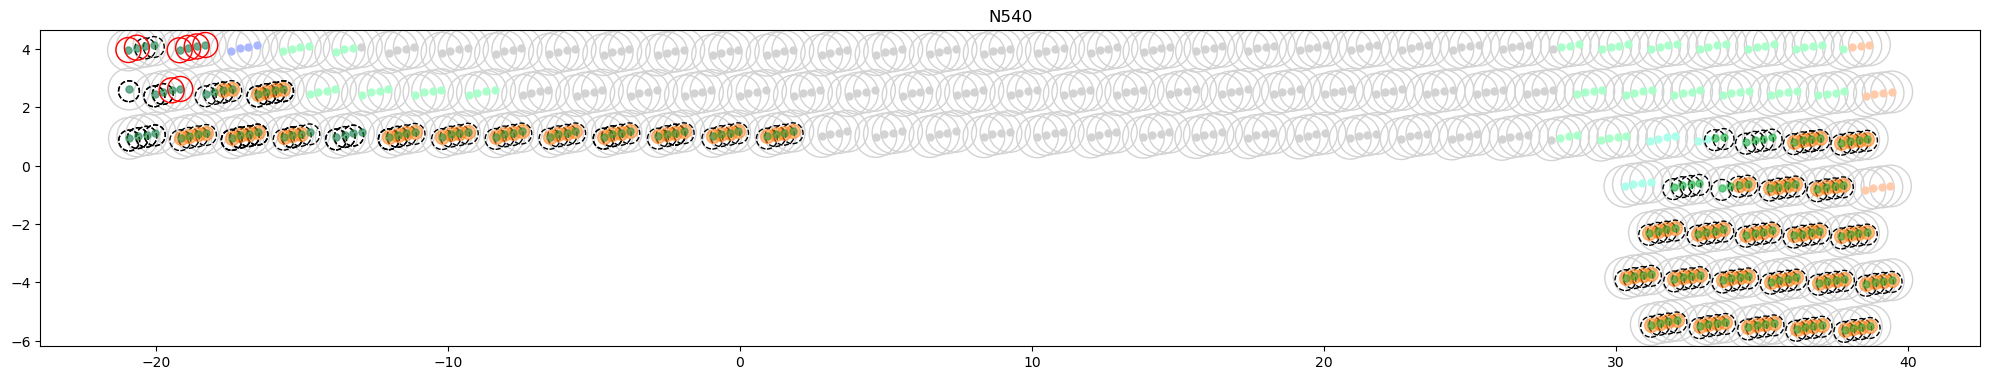

In [51]:
fields = ocat['object'].str.extract(r'(.*?(?=_))')[0]

fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

cc_l = ['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']
#['tab:red','tab:blue','tab:green','tab:purple','grey','tab:orange']
#['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']

plt.scatter ( wrapRA(hcat['RA']), hcat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_o.merian_sidecar['racenter']), coo_o.merian_sidecar['deccenter'], 
             facecolor='None', edgecolor='k', s=15**2, ls='--' )
plt.scatter ( wrapRA( ocat.loc[beforelastnight, 'RA'] ), wrapRA(ocat.loc[beforelastnight, 'dec']), facecolor='tab:orange', s=10**2, alpha=0.5 )

plt.scatter ( wrapRA( ocat.loc[lastnightobjects, 'RA'] ), wrapRA(ocat.loc[lastnightobjects, 'dec']), facecolor='tab:green', s=5**2, alpha=0.5 )


# \\ show pointings that need reobservation
#needs_reobservation = ocat.loc[np.in1d(ocat['object'],reobs)]
#plt.scatter ( wrapRA ( needs_reobservation['RA'] ), wrapRA( needs_reobservation['dec'] ), color='tab:blue', s=15**2 )

going_to_observe['odate'] = going_to_observe.apply(lambda x: x['qstamp'].split("_")[0], axis=1)

#grps = going_to_observe.groupby('odate')
#for idx,(name,grp) in enumerate(grps):
#    cc = plt.cm.Dark2(idx/grps.ngroups)
#    plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
#    print(grp.shape[0])
plt.scatter ( wrapRA(ocat.reindex(going_to_observe.index)['RA']), ocat.reindex(going_to_observe.index)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1 )

#plt.axvline(38.)
plt.title('N540')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/N540_20220930_prediction.png')

# Copy [OIII] observation to H$\alpha$

In [32]:
night = halpha_nights[3]

year = night[0]
month = night[1]
day = night[2]
#lastobs_day = day - 2
print(year,month,day)

2022 9 30


In [33]:
tele = pd.read_csv(tele_fname, index_col=0)
tele_dt = pd.to_datetime(tele['date'])
lastnight = pd._libs.tslibs.timestamps.Timestamp(year=year, month=month, day=lastobs_day, tz='UTC')

In [34]:
# \\ only allow for OIII footprint
observed_last_night = tele['object'] #.loc[tele_dt.apply(lambda x: x > lastnight),'object']

In [35]:
# \\ need to match OIII planned observations to Halpha catalog

# \\ load N708 & N540 pointings
halpha_locations = coordinates.SkyCoord( hcat['RA'], hcat['dec'], unit=('deg','deg'))
#planned_oiii_obscoords = coordinates.SkyCoord( ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['RA'], 
#                                               ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['dec'], 
#                                               unit=('deg','deg'))
lastnightobjects = np.in1d(ocat['object'], observed_last_night)
lastnightobjects[np.in1d(ocat.index, going_to_observe.index)] = True

oiii_FLO = coordinates.SkyCoord ( ocat.loc[lastnightobjects, 'RA'],
                                  ocat.loc[lastnightobjects, 'dec'],
                                  unit=('deg','deg') )

# \\ match via coordinates
matchids, sep, _ = oiii_FLO.match_to_catalog_sky ( halpha_locations )
matches = sep < 0.05*u.arcsec

# \\ aggregate all Halpha pointings that are in the OIII queue
nominally_new_inN708 = hcat.index[matchids]
#nominally_new_inN708['qstamp'] = to_obs['qstamp']
# \\ identify which pointings have already been observed in Halpha
already_observed_inN708 = np.in1d(hcat.reindex(nominally_new_inN708)['object'], coo_h.merian_sidecar['object'])
truly_new_inN708 = hcat.reindex(nominally_new_inN708).loc[~already_observed_inN708].copy()
#truly_new_inN708['qstamp'] = is_queued.query('is_queued').loc[~already_observed_inN708, 'qstamp'].values
#truly_new_inN708['object'] = truly_new_inN708['object'].apply ( lambda x: 'OIIIanalog_' + x.split('_')[1] )

# \\ the pointings that "can" be observed should be the truly new in queue
# \\ PLUS XMM pointings, but XMM should be downgraded
hcat_fields = hcat['object'].str.extract(r'(.*?(?=_))')[0]
is_xmm = hcat_fields == 'XMM'
#is_xv = hcat_fields == 'btwnXV'
xmmtogo = hcat.loc[is_xmm].copy ()
xmmtogo['qstamp'] = 'NONE'

hack_cat = pd.concat([truly_new_inN708, xmmtogo])
# \\ remove pointings that are both in XMM and scheduled for 
# \\ OIII observations
hack_cat = hack_cat.loc[~hack_cat.index.duplicated( keep='first')]
hack_cat['qstamp'] = hack_cat['qstamp'].replace(np.NaN, 'NONE')

In [40]:
#is_queued = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
halpha_priorities = {'VVDSearly':0, 'VVDSlate':0, 'VVDS':0, 'XMM':100, 'btwnXV':2, 'XMMhigh':4, 'newRAbtwnXV':5}


todaycat = hack_cat

#isqueuedtoday = pd.DataFrame(index=todaycat.index, columns=['is_queued','qstamp','airmass'])      
#isqueuedtoday['is_queued'] = False
dt = f'{night[0]}{night[1]:02d}{night[2]:02d}' #20220920
if not os.path.exists ( f'../json/{dt}'):
    os.mkdir(f'../json/{dt}')
    
stdout = sys.stdout
with open(f'../json/{dt}/output.log','w') as sys.stdout:
    is_queued_halpha = sigjson_f2022b.plan_tomorrow( day, month, year, 
                                             tele_fname, copilot_fname, mfilt='N708', 
                                             pointings=todaycat,
                                             is_queued=None, 
                                             exclude_hour_indices=[1,2],
                                             priorities = halpha_priorities,
                                             pad_last_hour=True, maxairmass=1.8, save=True, verbose=True)
sys.stdout = stdout

#os.rename( f'../json/{dt}', f'../json/{dt}_intermediateOIII')

#inq.extend(is_queued_halpha.index[~is_queued_halpha['qstamp'].isna()])

/Users/kadofong/work/surveys/merian/skipper/python/skipper/observe.py:406: UserWarning: Queue empty at 20220930_23
  warnings.warn (f'Queue empty at {hstr}')


In [48]:
# \\ DON'T SHOW PADDED TIME IN FIGURES
is_queued_halpha.loc[is_queued_halpha.loc[is_queued_halpha['qstamp'] == '20221001_09'].iloc[-6:].index, 'qstamp'] = np.NaN 

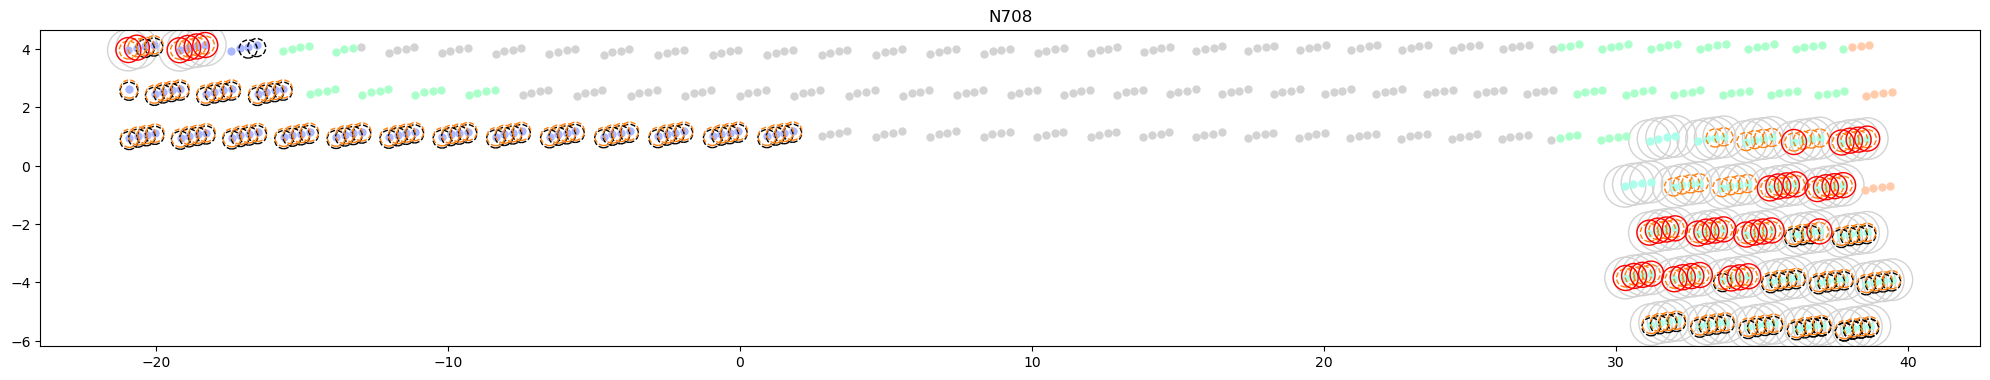

In [50]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

fields = ocat['object'].str.extract(r'(.*?(?=_))')[0]
cc_l = ['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']


plt.scatter ( wrapRA(hack_cat['RA']), hack_cat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), 
             coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2, ls='--' )

plt.scatter ( wrapRA(ocat.loc[lastnightobjects,'RA']), ocat.loc[lastnightobjects,'dec'], 
             facecolor='None', edgecolor='C1', s=13**2, lw=1, ls='--' )
plt.scatter ( wrapRA(hcat.reindex(is_queued_halpha.loc[~is_queued_halpha['qstamp'].isna()].index)['RA']), 
                     hcat.reindex(is_queued_halpha.loc[~is_queued_halpha['qstamp'].isna()].index)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1,  )

#plt.scatter ( wrapRA(truly_new_inN708['RA']), truly_new_inN708['dec'], facecolor='None', edgecolor='r', s=18**2, lw=1 )
#plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], color='b', s=1)

plt.title('N708')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/N708_20220930_prediction.png')

In [512]:
hack_queue = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
#hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True
hack_queue.loc[hcat.loc[np.in1d(hcat['object'], coo_h.merian_sidecar['object'])].index, 'is_queued'] = True
hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True

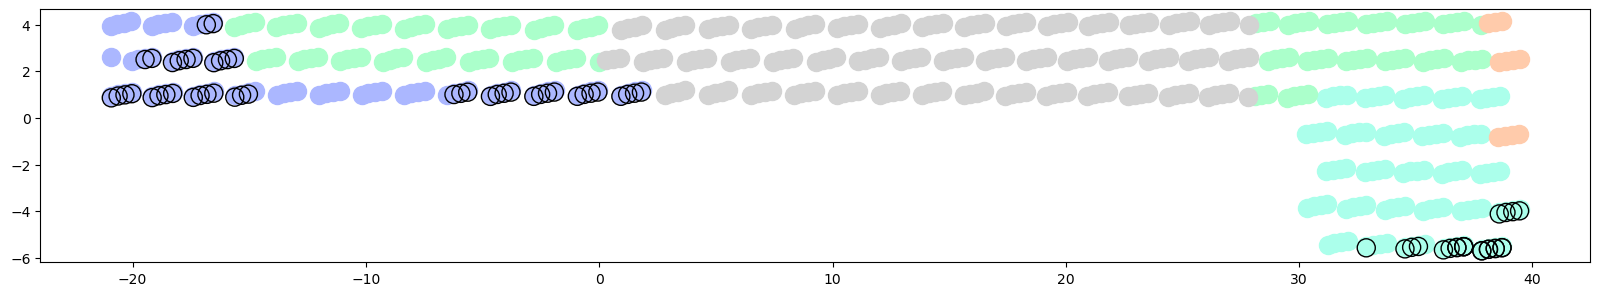

In [514]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b.priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=13**2)
    
plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2 )
hq = hack_queue.reindex ( coo_h.merian_sidecar
plt.scatter ( wrapRA(hcat.reindex(

In [ ]:
is_queued = None
for idx in range(len(halpha_nights)):
    night = halpha_nights[idx]
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N708', is_queued=is_queued, pad_last_hour=False, maxairmass=1.8, save=False, verbose=False)
to_obs = is_queued.loc[~is_queued['qstamp'].isna()]

In [229]:
#night = obsdates[4]
#newq = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N540', is_queued=is_queued, pad_last_hour=False, maxairmass=1.6, save=False)
    

In [506]:
5 - (5.*10./15.)

1.6666666666666665

In [199]:
coo_o.merian_sidecar.loc[coo_o.merian_sidecar['racenter'] > 300., 'racenter'].min()

340.8357782548524

In [202]:
coo_h.merian_sidecar.loc[coo_h.merian_sidecar['racenter'] > 300., 'racenter'].min()

339.08456994156114